In [103]:
import numpy as np
import xarray as xr
import climpred
from scipy.stats import t
import scipy
import xskillscore as xs

In [2]:
climpred.tutorial.load_dataset()

'MPI-control-1D': area averages for the MPI control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the MPI control run of SST/SSS.
'MPI-PM-DP-1D': perfect model decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': perfect model decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'CESM-DP-SST': hindcast decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': hindcast decadal prediction ensemble of global mean SSS.
'CESM-DP-SST-3D': hindcast decadal prediction ensemble of eastern Pacific SSTs.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': hindcast initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.
'FOSI

In [3]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST')
fosi = climpred.tutorial.load_dataset('FOSI-SST')

hindcast = climpred.HindcastEnsemble(hind)
hindcast = hindcast.add_reference(fosi, 'fosi')

In [32]:
p_eff = hindcast.compute_metric(metric='pearson_r_eff_p_value', comparison='e2r')
p = hindcast.compute_metric(metric='pearson_r_p_value')

In [33]:
n_eff = xr.open_dataset("n_eff.nc")
t = xr.open_dataset("t.nc")

In [34]:
def _calculate_p(t, n):
    return scipy.stats.t.sf(np.abs(t), n - 2) * 2

In [35]:
n = xr.zeros_like(n_eff)
n = n + 64

In [36]:
p_from_custom = xr.apply_ufunc(_calculate_p,
               t,
               n,
               dask="parallelized",
               output_dtypes=[float])

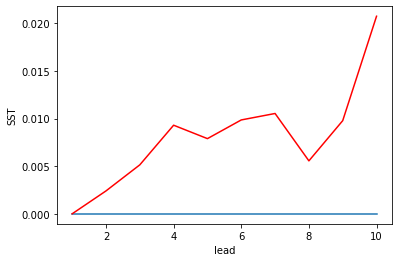

In [42]:
p.SST.plot()
p_from_custom.SST.plot(color='r')

Try scipy again

In [72]:
hind = climpred.tutorial.load_dataset('CESM-DP-SST')
fosi = climpred.tutorial.load_dataset('FOSI-SST')

hind = hind.mean('member')

fosi = fosi.sel(time=slice(1955, 2017))
# custom lead one correlation
hind = hind.isel(lead=0, init=slice(None, -1))
hind = hind.rename({'init': 'time'})
hind['time'] = np.arange(1955, 2018)
fosi['time'] = hind['time']

In [80]:
r, p = scipy.stats.pearsonr(hind.SST, fosi.SST)
p

8.063180801130821e-21

In [82]:
hindcast

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, member) float64 -0.2404 -0.2085 ... 0.7442 0.7384
fosi:
    SST      (time) float64 ...
Uninitialized:
    None

In [85]:
hindcast.compute_metric(metric='pacc').isel(lead=0).values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    lead     int32 1
Data variables:
    SST      float64 0.0007646
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     64
    number_of_members:             10
    metric:                        pearson_r_eff_p_value
    comparison:                    e2r
    units:                         None
    created:                       2019-12-18 12:14:25>

In [94]:
from climpred.metrics import Metric
import scipy
def _scipy_p(forecast, reference, dim=None, **metric_kwargs):
    r, p = xr.apply_ufunc(scipy.stats.pearsonr,
                          forecast.SST,
                          reference.SST)
    return p

_scipy_p = Metric(
    name='scipy_p',
    function=_scipy_p,
    probabilistic=False,
    positive=False,
    unit_power=0,
    )

In [95]:
hindcast.compute_metric(metric=_scipy_p)

ValueError: applied function returned data with unexpected number of dimensions: 0 vs 1, for dimensions ('time',)

**Try with a random time series**

Show that `xskillscore` and `scipy` have the same p-value.

In [97]:
a = xr.DataArray(np.random.rand(100,), dims=["time"])
b = xr.DataArray(np.random.rand(100,), dims=["time"])

In [101]:
r, p = scipy.stats.pearsonr(a, b)

In [106]:
p2 = xs.pearson_r_p_value(a, b, "time")

In [108]:
np.allclose(p, p2)

True

Show that `climpred` and `xskillscore` return the same results for one with alignment.

In [178]:
init = np.arange(1990, 2100)
time = np.arange(1990, 2101)
lead = np.arange(1, 2)
hind = xr.DataArray(np.random.rand(len(init), len(lead)),
                    dims=["init", "lead"],
                    coords=[init, lead])
obs = xr.DataArray(np.random.rand(len(time)),
                   dims=["time"],
                   coords=[time])

In [179]:
p1 = climpred.prediction.compute_hindcast(hind, obs, metric='pearson_r_p_value')

In [180]:
_, p2 = scipy.stats.pearsonr(hind.squeeze().values, obs.isel(time=slice(1, None)).values)

In [181]:
np.allclose(p1, p2)

True

Show that `climpred` effective p with N samples is the same as normal p.

In [193]:
from xskillscore import pearson_r
def _pearson_r_eff_p_value(forecast, reference, dim=None, **metric_kwargs):

    def _compute_autocorr(v, dim, n):
        """
        Return normal and shifted time series
        with equal dimensions so as not to
        throw an error.
        """
        shifted = v.isel({dim: slice(1, n)})
        normal = v.isel({dim: slice(0, n - 1)})
        # see explanation in autocorr for this
        if dim not in list(v.coords):
            normal[dim] = np.arange(1, n)
        shifted[dim] = normal[dim]
        return pearson_r(shifted, normal, dim)

    def _calculate_p(t, n):
        """Calculates the p-value.

        Args:
            t (ndarray): t-test statistic.
            n (ndarray): number of samples.

        Returns:
            p (ndarray): p-value.
        """
        return scipy.stats.t.sf(np.abs(t), n - 2) * 2

    n = forecast[dim].size
    # find autocorrelation
    fa, ra = forecast - forecast.mean(dim), reference - reference.mean(dim)
    fauto = _compute_autocorr(fa, dim, n)
    rauto = _compute_autocorr(ra, dim, n)
    # compute effective sample size
    n_eff = n * (1 - fauto * rauto) / (1 + fauto * rauto)
    n_eff = np.floor(n_eff)
    # constrain n_eff to be at the maximum the total number of samples
    n_eff = n_eff.where(n_eff <= n, n)
    # compute t-statistic
    weights = metric_kwargs.get('weights', None)
    skipna = metric_kwargs.get('skipna', False)
    r = pearson_r(forecast, reference, dim=dim, weights=weights, skipna=skipna)
    t = r * np.sqrt((n_eff - 2) / (1 - r ** 2))
    # compute effective p-value
    p = xr.apply_ufunc(_calculate_p, t, n_eff, dask="parallelized", output_dtypes=[float])
    return p

In [183]:
a = hind.squeeze()
a["init"] = np.arange(1991, 2101)
a = a.rename({'init': 'time'})

In [184]:
b = obs.sel(time=slice(1991, 2100))

In [188]:
p3 = _pearson_r_eff_p_value(a, b, dim="time")

In [194]:
eff_p = _pearson_r_eff_p_value(a, b, dim="time")